# Let's preprocess the data

In [1]:
import pandas as pd
import seaborn as sns
import glob
import os 
import re
import numpy as np

sns.set_theme()

## Pre visualisation

In [2]:
list_paths = glob.glob('./data_raw/*')
list_paths.sort()
print(list_paths)


df_test = pd.read_csv(list_paths[0], compression='gzip')

# Preview the data
df_test.head()

['./data_raw/20211201.csv.gz', './data_raw/20211202.csv.gz', './data_raw/20211203.csv.gz', './data_raw/20211206.csv.gz', './data_raw/20211207.csv.gz', './data_raw/20211208.csv.gz', './data_raw/20211209.csv.gz', './data_raw/20211210.csv.gz', './data_raw/20211213.csv.gz', './data_raw/20211214.csv.gz', './data_raw/20211215.csv.gz', './data_raw/20211216.csv.gz', './data_raw/20211217.csv.gz', './data_raw/20211220.csv.gz', './data_raw/20211221.csv.gz', './data_raw/20211222.csv.gz', './data_raw/20211223.csv.gz', './data_raw/20211227.csv.gz', './data_raw/20211228.csv.gz', './data_raw/20211229.csv.gz', './data_raw/20211230.csv.gz', './data_raw/20211231.csv.gz']


,DATE,SYMBOL,TIME,ALL_EX,MID_OPEN,SUM_DELTA
0,20211201,A,09:30:00,DNYBTJVPCZUKXHA,152.190,-8.401819
1,20211201,A,09:40:00,PBTJVDZUYKNHCXM,150.490,0.473357
2,20211201,A,09:50:00,KDPBTJVNZUCXYH,151.475,-10.867709
3,20211201,A,10:00:00,DABTJNKYVPZUXCH,150.510,-0.125414
4,20211201,A,10:10:00,DVJTPNKUZYACBXHM,151.960,-1.274648


## Selecting the appropriate tickers and building the data frame

In [3]:
url_dict = {
    'sp500': ("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies", 0, "Symbol"),
    'russell1000': ("https://en.wikipedia.org/wiki/Russell_1000_Index", 3, 'Symbol'),
    'ftse100': ("https://en.wikipedia.org/wiki/FTSE_100_Index", 4, "Ticker"),
}

In [4]:
list_tickers = []

for key, (url, table_index, ticker_column) in url_dict.items():
    if key in ['sp500']: #'russell1000', 'ftse100']:
        try:
            df = pd.read_html(url)[table_index]
            tickers = df[ticker_column].tolist()
            list_tickers += tickers
            print(f"{key}: {len(tickers)} tickers found.")
        except Exception as e:
            print(f"Error processing {key}: {e}")

sp500: 503 tickers found.


In [5]:
df_list = []

for path in list_paths:
    print(f"Processing file: {path.split('/')[-1]}")
    df = pd.read_csv(path, compression='gzip')
    df['SYMBOL'] = df['SYMBOL'].str.upper()
    df = df[df['SYMBOL'].isin(list_tickers)]
    df_list.append(df)

Processing file: 20211201.csv.gz
Processing file: 20211202.csv.gz
Processing file: 20211203.csv.gz
Processing file: 20211206.csv.gz
Processing file: 20211207.csv.gz
Processing file: 20211208.csv.gz
Processing file: 20211209.csv.gz
Processing file: 20211210.csv.gz
Processing file: 20211213.csv.gz
Processing file: 20211214.csv.gz
Processing file: 20211215.csv.gz
Processing file: 20211216.csv.gz
Processing file: 20211217.csv.gz
Processing file: 20211220.csv.gz
Processing file: 20211221.csv.gz
Processing file: 20211222.csv.gz
Processing file: 20211223.csv.gz
Processing file: 20211227.csv.gz
Processing file: 20211228.csv.gz
Processing file: 20211229.csv.gz
Processing file: 20211230.csv.gz
Processing file: 20211231.csv.gz


In [6]:
df = pd.concat(df_list, ignore_index=True)

df = df.drop(columns=['ALL_EX', 'SUM_DELTA'])

df['DATE_FORMATTED'] = df['DATE'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:8])
df['DATE_FORMATTED'] = pd.to_datetime(df['DATE_FORMATTED'], format='%Y-%m-%d')
df['DATETIME'] = pd.to_datetime(df['DATE_FORMATTED'].astype(str) + ' ' + df['TIME'])
df['DAY_OF_THE_WEEK'] = df['DATETIME'].dt.day_name()
df['HOUR_OF_DAY'] = df['DATETIME'].dt.hour
# df = df.drop(columns=['DATE', 'TIME'])

df = df.sort_values(by=['SYMBOL', 'DATETIME'])

df.head()


,DATE,SYMBOL,TIME,MID_OPEN,DATE_FORMATTED,DATETIME,DAY_OF_THE_WEEK,HOUR_OF_DAY
0,20211201,A,09:30:00,152.190,2021-12-01,2021-12-01 09:30:00,Wednesday,9
1,20211201,A,09:40:00,150.490,2021-12-01,2021-12-01 09:40:00,Wednesday,9
2,20211201,A,09:50:00,151.475,2021-12-01,2021-12-01 09:50:00,Wednesday,9
3,20211201,A,10:00:00,150.510,2021-12-01,2021-12-01 10:00:00,Wednesday,10
4,20211201,A,10:10:00,151.960,2021-12-01,2021-12-01 10:10:00,Wednesday,10


In [7]:
df.to_csv('./data_clean/processed_data_no_features.csv', index=False)

## Building the features

Here a little summary of the different features we construct given the price of each stock :

- rolling volatility : vol_n
- rolling mean : mean_n
- rolling sharpe ratio : sr_n
- rolling skewness : skew_n
- rolling kurtosis : kurt_n
- rolling minimum return : min_n
- rolling maximum return : max_n
- rolling zscore : zscore_n
- rolling log momentum : log_momentum_n
- exponential weighted mean : ewm_n

In [8]:
def compute_features_intraday(df, price_col='MID_OPEN', log_return_col='LOG_RETURN',
                               group_col='SYMBOL', rolling_windows=[5, 10, 14, 20, 32, 45, 60]):
    df = df.copy()

    # Ensure datetime index is sorted
    df = df.sort_index()

    # Step 1: Compute log returns (if not already)
    if log_return_col not in df.columns:
        df[log_return_col] = df.groupby(group_col)[price_col].transform(lambda x: np.log(x / x.shift(1)))

    def rolling_max_drawdown(series, window):
        max_dd = pd.Series(index=series.index, dtype='float64')
        for i in range(window, len(series)):
            window_data = series.iloc[i - window:i]
            peak = window_data.max()
            trough = window_data.min()
            dd = (trough - peak) / peak
            max_dd.iloc[i] = dd
        return max_dd

    # Step 2: Apply rolling features per group (symbol)
    def apply_rolling(group):
        group = group.sort_index()
        temp_features = {}

        for n in rolling_windows:
            log_ret = group[log_return_col]
            price = group[price_col]

            temp_features[f'vol_{n}'] = log_ret.rolling(n).std()
            temp_features[f'mean_{n}'] = log_ret.rolling(n).mean()
            temp_features[f'sr_{n}'] = temp_features[f'mean_{n}'] / temp_features[f'vol_{n}']
            temp_features[f'skew_{n}'] = log_ret.rolling(n).skew()
            temp_features[f'kurt_{n}'] = log_ret.rolling(n).kurt()
            temp_features[f'min_{n}'] = log_ret.rolling(n).min()
            temp_features[f'max_{n}'] = log_ret.rolling(n).max()
            temp_features[f'zscore_{n}'] = (price - temp_features[f'mean_{n}']) / temp_features[f'vol_{n}']
            temp_features[f'log_momentum_{n}'] = log_ret.rolling(n).sum()
            temp_features[f'ewm_{n}'] = log_ret.ewm(span=n, adjust=False).mean()
            temp_features[f'bb_upper_{n}'] = temp_features[f'mean_{n}'] + 2 * temp_features[f'vol_{n}']
            temp_features[f'bb_lower_{n}'] = temp_features[f'mean_{n}'] - 2 * temp_features[f'vol_{n}']
            temp_features[f'mdd_{n}'] = rolling_max_drawdown(price, n)

        # MACD section
        temp_features['ema_12'] = price.ewm(span=12, adjust=False).mean()
        temp_features['ema_26'] = price.ewm(span=26, adjust=False).mean()
        temp_features['macd'] = temp_features['ema_12'] - temp_features['ema_26']
        temp_features['macd_signal'] = temp_features['macd'].ewm(span=9, adjust=False).mean()
        temp_features['macd_hist'] = temp_features['macd'] - temp_features['macd_signal']

        # Concatenate all at once to avoid fragmentation
        features_df = pd.concat(temp_features, axis=1)
        group = pd.concat([group, features_df], axis=1)

        return group


    # Apply safely with group_keys=False
    df = df.groupby(group_col, group_keys=False).apply(apply_rolling)

    df = df.sort_values(by=['SYMBOL', 'DATETIME'])
    # Drop initial NaNs from rolling calculations
    # df = df.dropna()

    return df


In [9]:
df = compute_features_intraday(df, price_col='MID_OPEN', log_return_col='LOG_RETURN')

/var/folders/gj/_zj9fp956_xcqqmpq5fvknt00000gn/T/ipykernel_60474/3615734625.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(group_col, group_keys=False).apply(apply_rolling)


In [10]:
df.to_csv('./data_clean/processed_data_with_features.csv', index=False)

## Plotting / Debugging

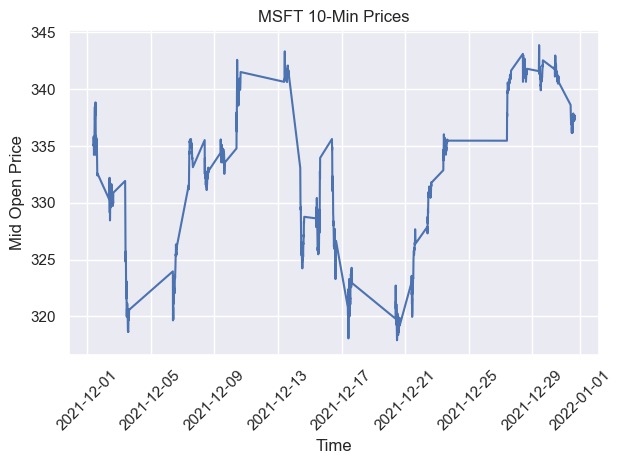

In [11]:
import matplotlib.pyplot as plt

subset = df[df['SYMBOL'] == 'MSFT']
plt.plot(subset['DATETIME'], subset['MID_OPEN'])
plt.xlabel("Time")
plt.ylabel("Mid Open Price")
plt.title("MSFT 10-Min Prices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

df_test = pd.read_csv('./data_clean/processed_data_with_features.csv')

In [13]:
df_test.head()

,DATE,SYMBOL,TIME,MID_OPEN,DATE_FORMATTED,DATETIME,DAY_OF_THE_WEEK,HOUR_OF_DAY,LOG_RETURN,vol_5,...,log_momentum_60,ewm_60,bb_upper_60,bb_lower_60,mdd_60,ema_12,ema_26,macd,macd_signal,macd_hist
0,20211201,A,09:30:00,152.190,2021-12-01,2021-12-01 09:30:00,Wednesday,9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,152.190000,152.190000,0.000000,0.000000,0.000000
1,20211201,A,09:40:00,150.490,2021-12-01,2021-12-01 09:40:00,Wednesday,9,-0.011233,NaN,...,NaN,-0.011233,NaN,NaN,NaN,151.928462,152.064074,-0.135613,-0.027123,-0.108490
2,20211201,A,09:50:00,151.475,2021-12-01,2021-12-01 09:50:00,Wednesday,9,0.006524,NaN,...,NaN,-0.010651,NaN,NaN,NaN,151.858698,152.020439,-0.161741,-0.054046,-0.107695
3,20211201,A,10:00:00,150.510,2021-12-01,2021-12-01 10:00:00,Wednesday,10,-0.006391,NaN,...,NaN,-0.010511,NaN,NaN,NaN,151.651206,151.908555,-0.257348,-0.094707,-0.162642
4,20211201,A,10:10:00,151.960,2021-12-01,2021-12-01 10:10:00,Wednesday,10,0.009588,NaN,...,NaN,-0.009852,NaN,NaN,NaN,151.698713,151.912365,-0.213652,-0.118496,-0.095157
